# Jupyter notebook based on ImageD11 to process scanning 3DXRD data
# Written by Haixing Fang, Jon Wright and James Ball
## Date: 12/10/2024

This notebook will try to find good grain orientations from a 4D merge of your peak data.  
This means your peaks have been merged across omega and dty.  
This notebook (and the tomo route in general) works best for low levels of deformation.  
If it doesn't seem to work well, try the point-by-point route instead!

In [1]:
exec(open('/data/id11/nanoscope/install_ImageD11_from_git.py').read())

In [2]:
# this cell is tagged with 'parameters'
# to view the tag, select the cell, then find the settings gear icon (right or left sidebar) and look for Cell Tags

# python environment stuff
PYTHONPATH = setup_ImageD11_from_git( ) # ( os.path.join( os.environ['HOME'],'Code'), 'ImageD11_git' )

# dataset file to import
dset_file = 'si_cube_test/processed/Si_cube/Si_cube_S3DXRD_nt_moves_dty/Si_cube_S3DXRD_nt_moves_dty_dataset.h5'

# which phase to index
phase_str = 'Si'

# peak filtration parameters
cf_strong_frac = 0.9939
cf_strong_dsmax = 1.594
cf_strong_dstol = 0.005

# indexing parameters
indexer_ds_tol = 0.01
# we have to choose which rings we want to generate orientations on
# generally we want two or three low-multiplicity rings that are isolated from other phases
# take a look at the ring assignment output from a few cells above, and choose two or three
rings_for_gen = [0, 1, 3]
# now we want to decide which rings to score our found orientations against
# generally we can just exclude dodgy rings (close to other phases, only a few peaks in etc)
rings_for_scoring = [0, 1, 2, 3, 4]
# the sequence of hkl tolerances the indexer will iterate through
hkl_tols_seq = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.075]
# the sequence of minpks fractions the indexer will iterate through
fracs = [0.9, 0.7]
# the max number of UBIs we can find per pair of rings
max_grains = 1000

peak_assign_tol = 0.05

# Setting path via: 
sys.path.insert(0, /home/esrf/james1997a/Code/ImageD11 )


# Running from: /home/esrf/james1997a/Code/ImageD11/ImageD11/__init__.py


In [3]:
# Parameters
PYTHONPATH = "../"
dset_file = "tomo_route/processed/Si_cube/Si_cube_S3DXRD_nt_moves_dty/Si_cube_S3DXRD_nt_moves_dty_dataset.h5"
phase_str = "Si"
cf_strong_frac = 0.9939
cf_strong_dsmax = 1.594
cf_strong_dstol = 0.005
indexer_ds_tol = 0.01
rings_for_gen = [0, 1, 3]
rings_for_scoring = [0, 1, 2, 3, 4]
hkl_tols_seq = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.075]
fracs = [0.9, 0.7]
max_grains = 1000
peak_assign_tol = 0.05


In [4]:
# import functions we need

import h5py
import numpy as np

import matplotlib
%matplotlib ipympl
from matplotlib import pyplot as plt

import ImageD11.nbGui.nb_utils as utils

import ImageD11.grain
import ImageD11.indexing
import ImageD11.columnfile
from ImageD11.unitcell import Phases
from ImageD11.peakselect import select_ring_peaks_by_intensity

In [5]:
# USER: Pass path to dataset file

ds = ImageD11.sinograms.dataset.load(dset_file)
   
sample = ds.sample
dataset = ds.dsname
rawdata_path = ds.dataroot
processed_data_root_dir = ds.analysisroot

print(ds)
print(ds.shape)

dataroot = "/home/esrf/james1997a/Code/ImageD11/test/tomo_route/raw"
analysisroot = "/home/esrf/james1997a/Code/ImageD11/test/tomo_route/processed"
sample = "Si_cube"
dset = "S3DXRD_nt_moves_dty"
shape = ( 41, 3620)
# scans 41 from 1.1 to 41.1
(41, 3620)


In [6]:
# USER: specify the path to the parameter file
# you can find an example json in the same folder as this notebook

par_file = os.path.join(processed_data_root_dir, 'pars.json')

# add them to the dataset

ds.parfile = par_file

ds.save()

In [7]:
# load phases from parameter file

ds.phases = ds.get_phases_from_disk()
ds.phases.unitcells

{'Si': <ImageD11.unitcell.unitcell at 0x151b756579d0>}

In [8]:
# now let's select a phase to index from our parameters json

ucell = ds.phases.unitcells[phase_str]

print(ucell.lattice_parameters, ucell.spacegroup)

[ 5.43  5.43  5.43 90.   90.   90.  ] 227


In [9]:
# We will now generate a cf (columnfile) object for the 4D peaks.
# Will be corrected for detector spatial distortion

cf_4d = ds.get_cf_4d()
ds.update_colfile_pars(cf_4d, phase_name=phase_str)

if not os.path.exists(ds.col4dfile):
    # save the 4D peaks to file so we don't have to spatially correct them again
    ImageD11.columnfile.colfile_to_hdf(cf_4d, ds.col4dfile)

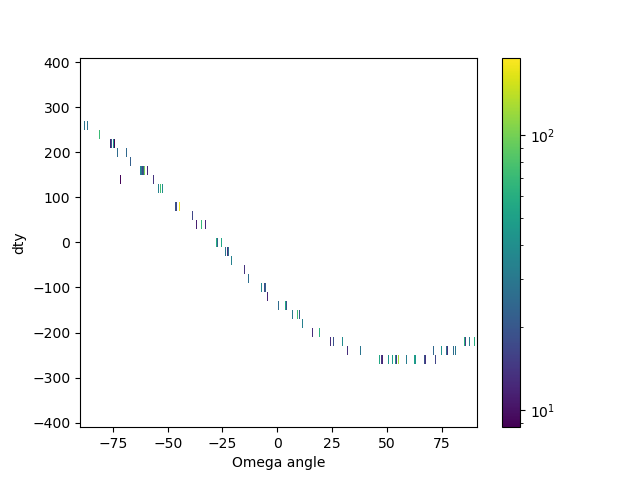

In [10]:
# Generate a mask that selects only 4D peaks greater than 25 pixels in size

m = cf_4d['Number_of_pixels'] > 25

# then plot omega vs dty for all peaks - should look sinusoidal

fig, ax = plt.subplots()
counts, xedges, yedges, im = ax.hist2d(cf_4d['omega'][m], cf_4d['dty'][m], weights=np.sqrt(cf_4d['sum_intensity'][m]), bins=(ds.obinedges, ds.ybinedges), norm=matplotlib.colors.LogNorm())
ax.set_xlabel("Omega angle")
ax.set_ylabel("dty")

fig.colorbar(im, ax=ax)

plt.show()

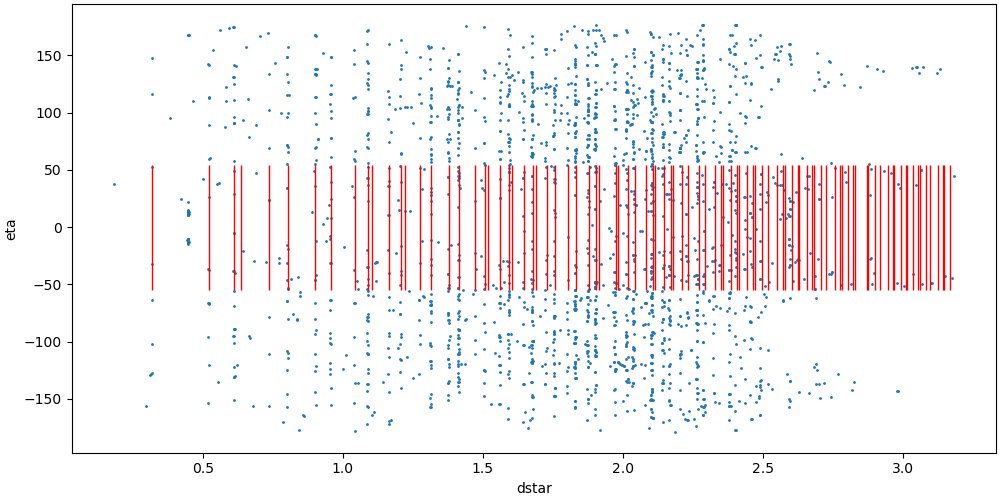

In [11]:
# plot the 4D peaks (fewer of them) as a cake (two-theta vs eta)
# if the parameters in the par file are good, these should look like straight lines

ucell.makerings(cf_4d.ds.max())

fig, ax = plt.subplots(figsize=(10,5), layout='constrained')

ax.scatter(cf_4d.ds, cf_4d.eta, s=1)
ax.plot( ucell.ringds, [0,]*len(ucell.ringds), '|', ms=90, c="red")
ax.set_xlabel("dstar")
ax.set_ylabel("eta")

plt.show()

In [12]:
# OPTIONAL: export CF to an flt so we can play with it with ImageD11_gui
# uncomment the below line

# cf_4d.writefile(f'{sample}_{dataset}_4d_peaks.flt')

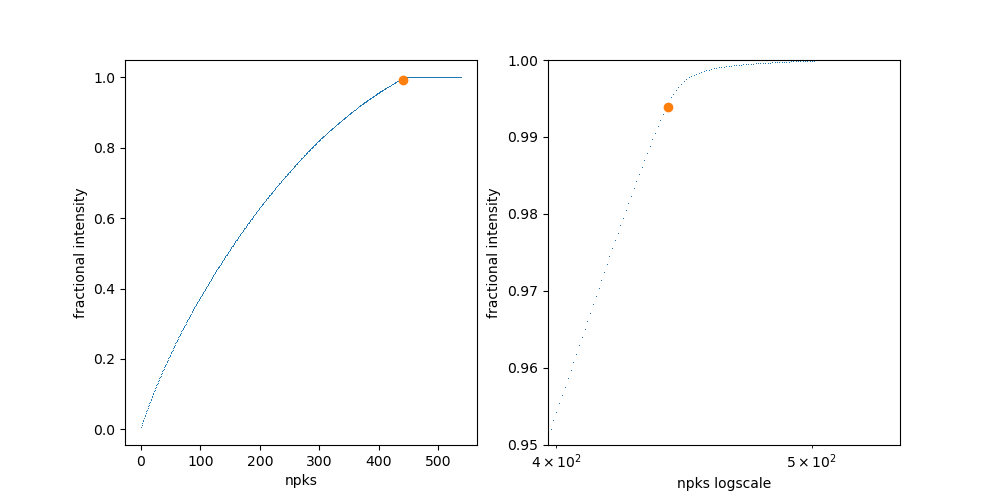

2621
441


In [13]:
# here we are filtering our peaks (cf_4d) to select only the strongest ones for indexing purposes only!
# dsmax is being set to limit rings given to the indexer - 6-8 rings is normally good

# USER: modify the "frac" parameter  and re-run the cell until the orange dot sits nicely on the "elbow" of the blue line
# this indicates the fractional intensity cutoff we will select
# if the blue line does not look elbow-shaped in the logscale plot, try changing the "doplot" parameter (the y scale of the logscale plot) until it does

cf_strong = select_ring_peaks_by_intensity(cf_4d, frac=cf_strong_frac, dsmax=cf_strong_dsmax, dstol=cf_strong_dstol, doplot=0.95)
print(cf_4d.nrows)
print(cf_strong.nrows)

In [14]:
# OPTIONAL: export CF to an flt so we can play with it with ImageD11_gui
# uncomment the below line

# cf_strong.writefile(f'{sample}_{dataset}_strong_4d_peaks.flt')

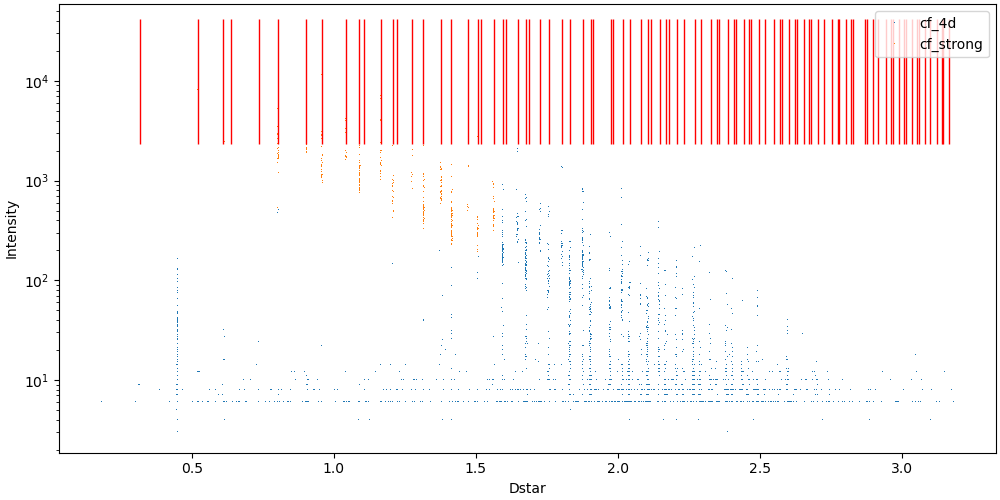

In [15]:
# now we can take a look at the intensities of the remaining peaks

fig, ax = plt.subplots(figsize=(10, 5), constrained_layout=True)

ax.plot(cf_4d.ds, cf_4d.sum_intensity,',', label='cf_4d')
ax.plot(cf_strong.ds, cf_strong.sum_intensity,',', label='cf_strong')
ax.plot( ucell.ringds, [1e4,]*len(ucell.ringds), '|', ms=90, c="red")

ax.semilogy()

ax.set_xlabel("Dstar")
ax.set_ylabel("Intensity")
ax.legend()

plt.show()

In [16]:
# specify our ImageD11 indexer with these peaks

indexer = ImageD11.indexing.indexer_from_colfile(cf_strong)

print(f"Indexing {cf_strong.nrows} peaks")

info: gv: [[-0.28796369 -0.08811866  0.67285429]
 [-0.15936549  0.02120938  0.94373222]
 [ 0.80085816  0.52461954  0.41184688]
 ...
 [-1.05162433 -0.14468653 -1.06678512]
 [ 1.34039133 -0.43511133 -0.09244712]
 [-1.22046365 -0.05902335  0.48174911]] (441, 3) float64
Indexing 441 peaks


In [17]:
# USER: set a tolerance in d-space (for assigning peaks to powder rings)

indexer.ds_tol = indexer_ds_tol

# change the log level so we can see what the ring assigments look like

ImageD11.indexing.loglevel = 1

# assign peaks to powder rings

indexer.assigntorings()

# change log level back again

ImageD11.indexing.loglevel = 3

info: Assign to rings, maximum d-spacing considered: 1.563382
info: Ring assignment array shape (441,)
info: Ring     (  h,  k,  l) Mult  total indexed to_index  ubis  peaks_per_ubi   tth
info: Ring 21  ( -2, -2, -8)   36     31       0       31     0     34  17.32
info: Ring 20  ( -4, -6, -4)   24      0       0        0     0     22  16.83
info: Ring 19  ( -3, -3, -7)   24     19       0       19     0     22  16.70
info: Ring 18  (  0, -8,  0)    6      6       0        6     1      5  16.32
info: Ring 17  ( -5, -5, -3)   72     63       0       63     0     68  15.67
info: Ring 16  ( -6, -2, -4)   48     43       0       43     0     45  15.26
info: Ring 15  ( -1, -7, -1)   48     47       0       47     1     45  14.56
info: Ring 14  ( -4, -4, -4)    8      8       0        8     1      7  14.12
info: Ring 13  ( -2, -6, -2)   24      0       0        0     0     22  13.52
info: Ring 12  ( -3, -5, -3)   24     22       0       22     0     22  13.36
info: Ring 11  ( -2, -6,  0)   2

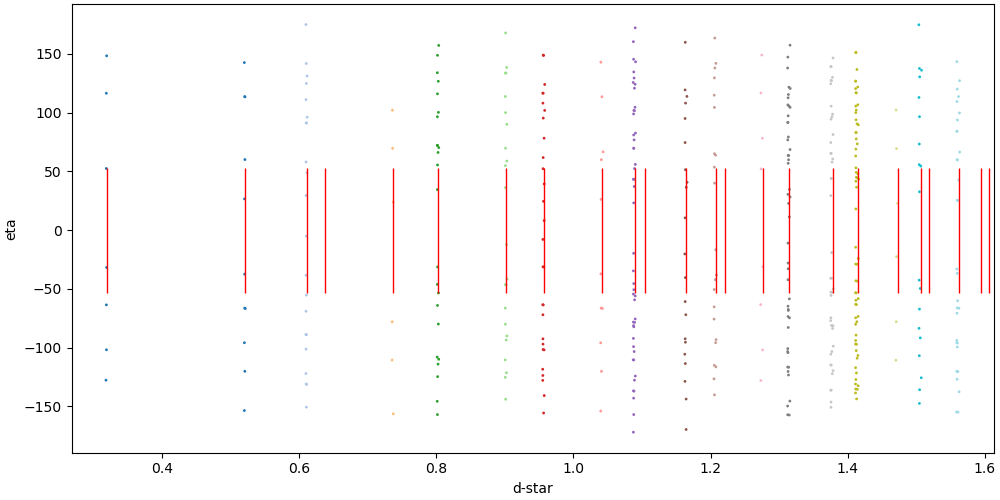

In [18]:
# let's plot the assigned peaks

fig, ax = plt.subplots(layout='constrained', figsize=(10,5))

# indexer.ra is the ring assignments

ax.scatter(cf_strong.ds, cf_strong.eta, c=indexer.ra, cmap='tab20', s=1)
ax.plot( ucell.ringds, [0,]*len(ucell.ringds), '|', ms=90, c="red")
ax.set_xlim(cf_strong.ds.min()-0.05, cf_strong.ds.max()+0.05)
ax.set_xlabel("d-star")
ax.set_ylabel("eta")

plt.show()

In [19]:
# now we are indexing!
# the tolerance in g-vector angle - automatically computed from dataset
cosine_tol = np.cos(np.radians(90 - ds.ostep))

grains, indexer = utils.do_index(cf=cf_strong,
                                 unitcell=ds.phases.unitcells[phase_str],
                                 dstol=indexer_ds_tol,
                                 forgen=rings_for_gen,
                                 foridx=rings_for_scoring,
                                 hkl_tols=hkl_tols_seq,
                                 fracs=fracs,
                                 cosine_tol=cosine_tol,
                                 max_grains=max_grains,
                                
)
print(f'Found {len(grains)} grains!')

9 peaks expected
Trying these rings (counts, multiplicity, ring number): [(7, 8, 0), (11, 12, 1)]
0.9 0.01 1
0.9 0.02 1
0.9 0.03 1
0.9 0.04 1
0.9 0.05 1
0.9 0.06 1
0.9 0.075 1
0.7 0.01 1
0.7 0.02 1
0.7 0.03 1
0.7 0.04 1
0.7 0.05 1
0.7 0.06 1
0.7 0.075 1
Found 1 grains!


In [20]:
# add temporary grain IDs to the grains

for ginc, g in enumerate(grains):
    g.gid = ginc

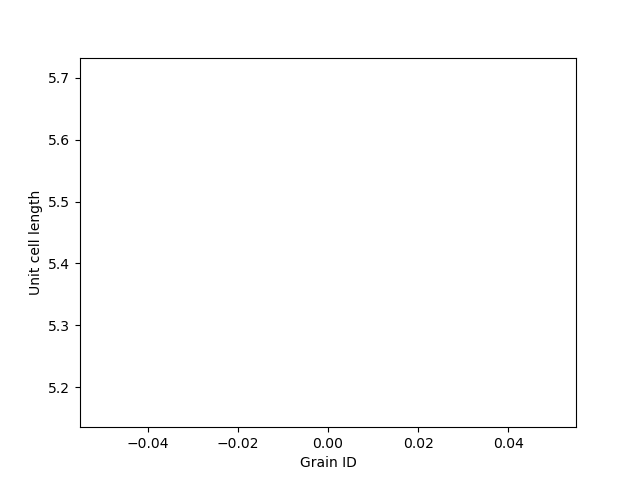

5.433969351073947


In [21]:
mean_unit_cell_lengths = [np.cbrt(np.linalg.det(g.ubi)) for g in grains]

fig, ax = plt.subplots()
ax.plot(mean_unit_cell_lengths)
ax.set_xlabel("Grain ID")
ax.set_ylabel("Unit cell length")
plt.show()

a0 = np.median(mean_unit_cell_lengths)
    
print(a0)

In [22]:
# assign peaks to grains

utils.assign_peaks_to_grains(grains, cf_strong, tol=peak_assign_tol)

Scoring and assigning 1 grains


  0%|          | 0/1 [00:00<?, ?it/s]

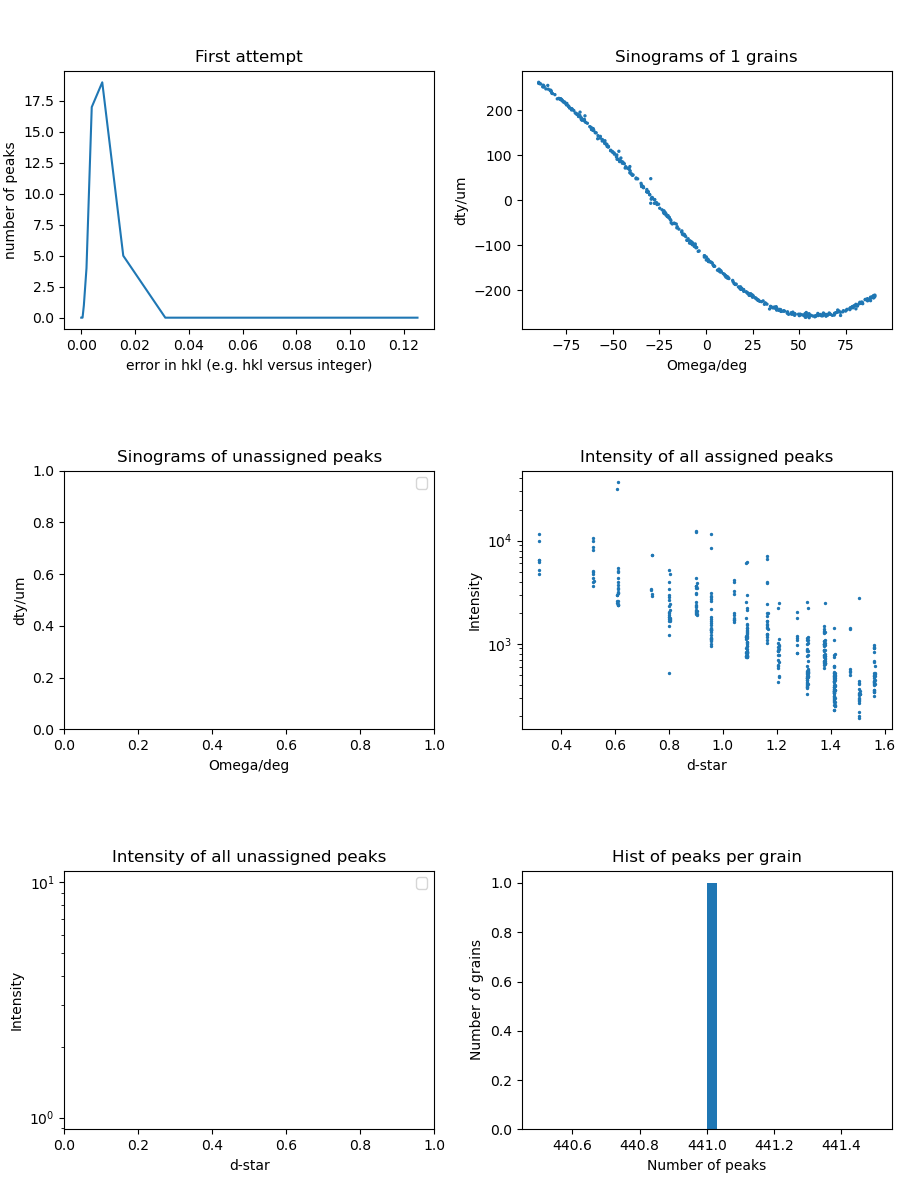

In [23]:
utils.plot_index_results(indexer, cf_strong, 'First attempt')

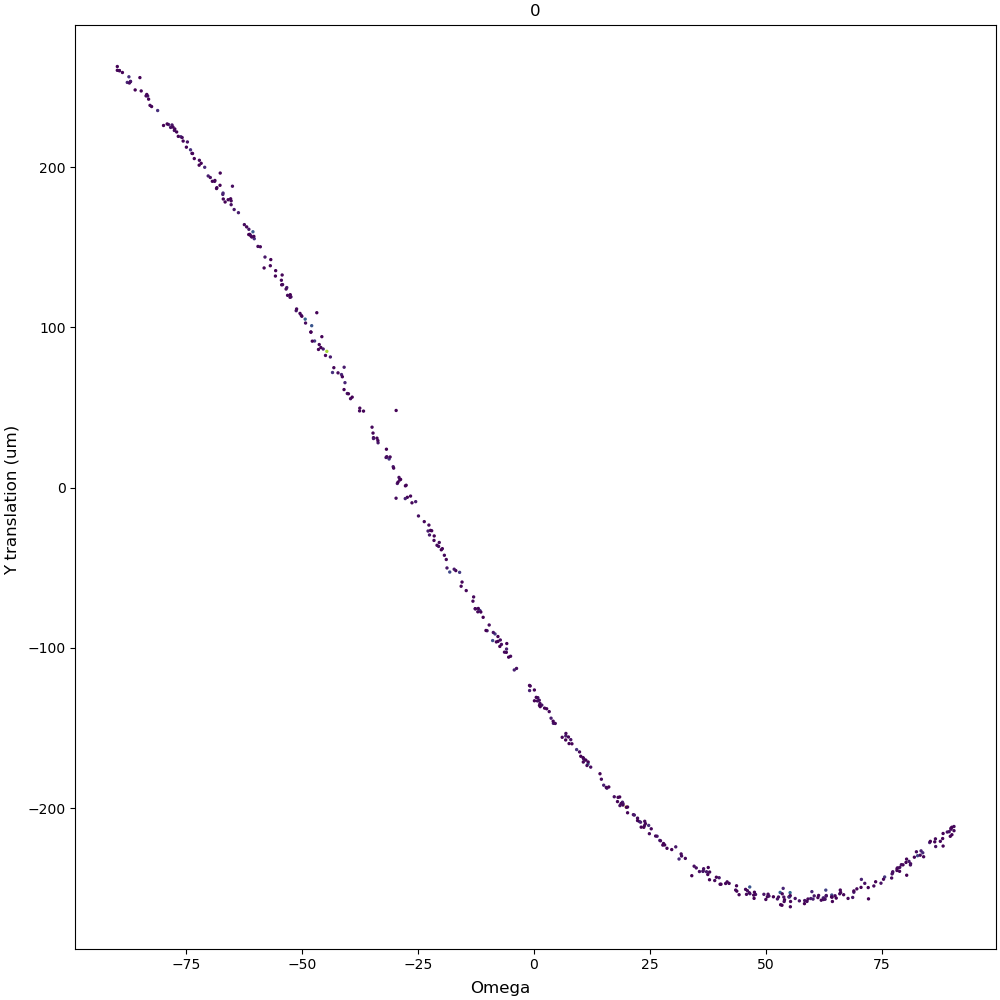

In [24]:
utils.plot_grain_sinograms(grains, cf_strong, min(len(grains), 25))

In [25]:
# save grain data

ds.save_grains_to_disk(grains, phase_name=phase_str)

In [26]:
# save new things to the dataset

ds.save()

In [27]:
# Now that we're happy with our indexing parameters, we can run the below cell to do this in bulk for many samples/datasets
# by default this will do all samples in sample_list, all datasets with a prefix of dset_prefix
# you can add samples and datasets to skip in skips_dict

skips_dict = {
    "FeAu_0p5_tR_nscope": ["top_-50um", "top_-100um"]
}

dset_prefix = "top"

sample_list = ["FeAu_0p5_tR_nscope"]
    
samples_dict = utils.find_datasets_to_process(rawdata_path, skips_dict, dset_prefix, sample_list)
    
# manual override:
# samples_dict = {"FeAu_0p5_tR_nscope": ["top_100um", "top_150um"]}
    
# now we have our samples_dict, we can process our data:

for sample, datasets in samples_dict.items():
    for dataset in datasets:
        print(f"Processing dataset {dataset} in sample {sample}")
        dset_path = os.path.join(processed_data_root_dir, sample, f"{sample}_{dataset}", f"{sample}_{dataset}_dataset.h5")
        if not os.path.exists(dset_path):
            print(f"Missing DataSet file for {dataset} in sample {sample}, skipping")
            continue
        
        print("Importing DataSet object")
        
        ds = ImageD11.sinograms.dataset.load(dset_path)
        print(f"I have a DataSet {ds.dset} in sample {ds.sample}")

        if os.path.exists(ds.grainsfile):
            # check grains file for existance of minor phase, skip if it's there
            with h5py.File(ds.grainsfile, "r") as hin:
                if phase_str in hin.keys():
                    print(f"Already have grains for {dataset} in sample {sample}, skipping")
                    continue
        
        
        ds.parfile = par_file
        ds.phases = ds.get_phases_from_disk()
        
        cf_4d = ds.get_cf_4d()
        ds.update_colfile_pars(cf_4d, phase_name=phase_str)

        if not os.path.exists(ds.col4dfile):
            # save the 4D peaks to file so we don't have to spatially correct them again
            ImageD11.columnfile.colfile_to_hdf(cf_4d, ds.col4dfile)
        
        cf_strong = select_ring_peaks_by_intensity(cf_4d, frac=cf_strong_frac, dsmax=cf_strong_dsmax, dstol=cf_strong_dstol)

        grains, indexer = utils.do_index(cf=cf_strong,
                                         unitcell=ds.phases.unitcells[phase_str],
                                        dstol=indexer_ds_tol,
                                        forgen=rings_for_gen,
                                        foridx=rings_for_scoring,
                                        hkl_tols=hkl_tols_seq,
                                        fracs=fracs,
                                        cosine_tol=cosine_tol,
                                        max_grains=max_grains
        )
            

        ds.save_grains_to_disk(grains, phase_name=phase_str)
        
        ds.save()

print("Done!")

Done!
